# Part A: Linear Classification Models

### A1. Data Preparation

##### Import Needed Libraries

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

#### Read Dataset

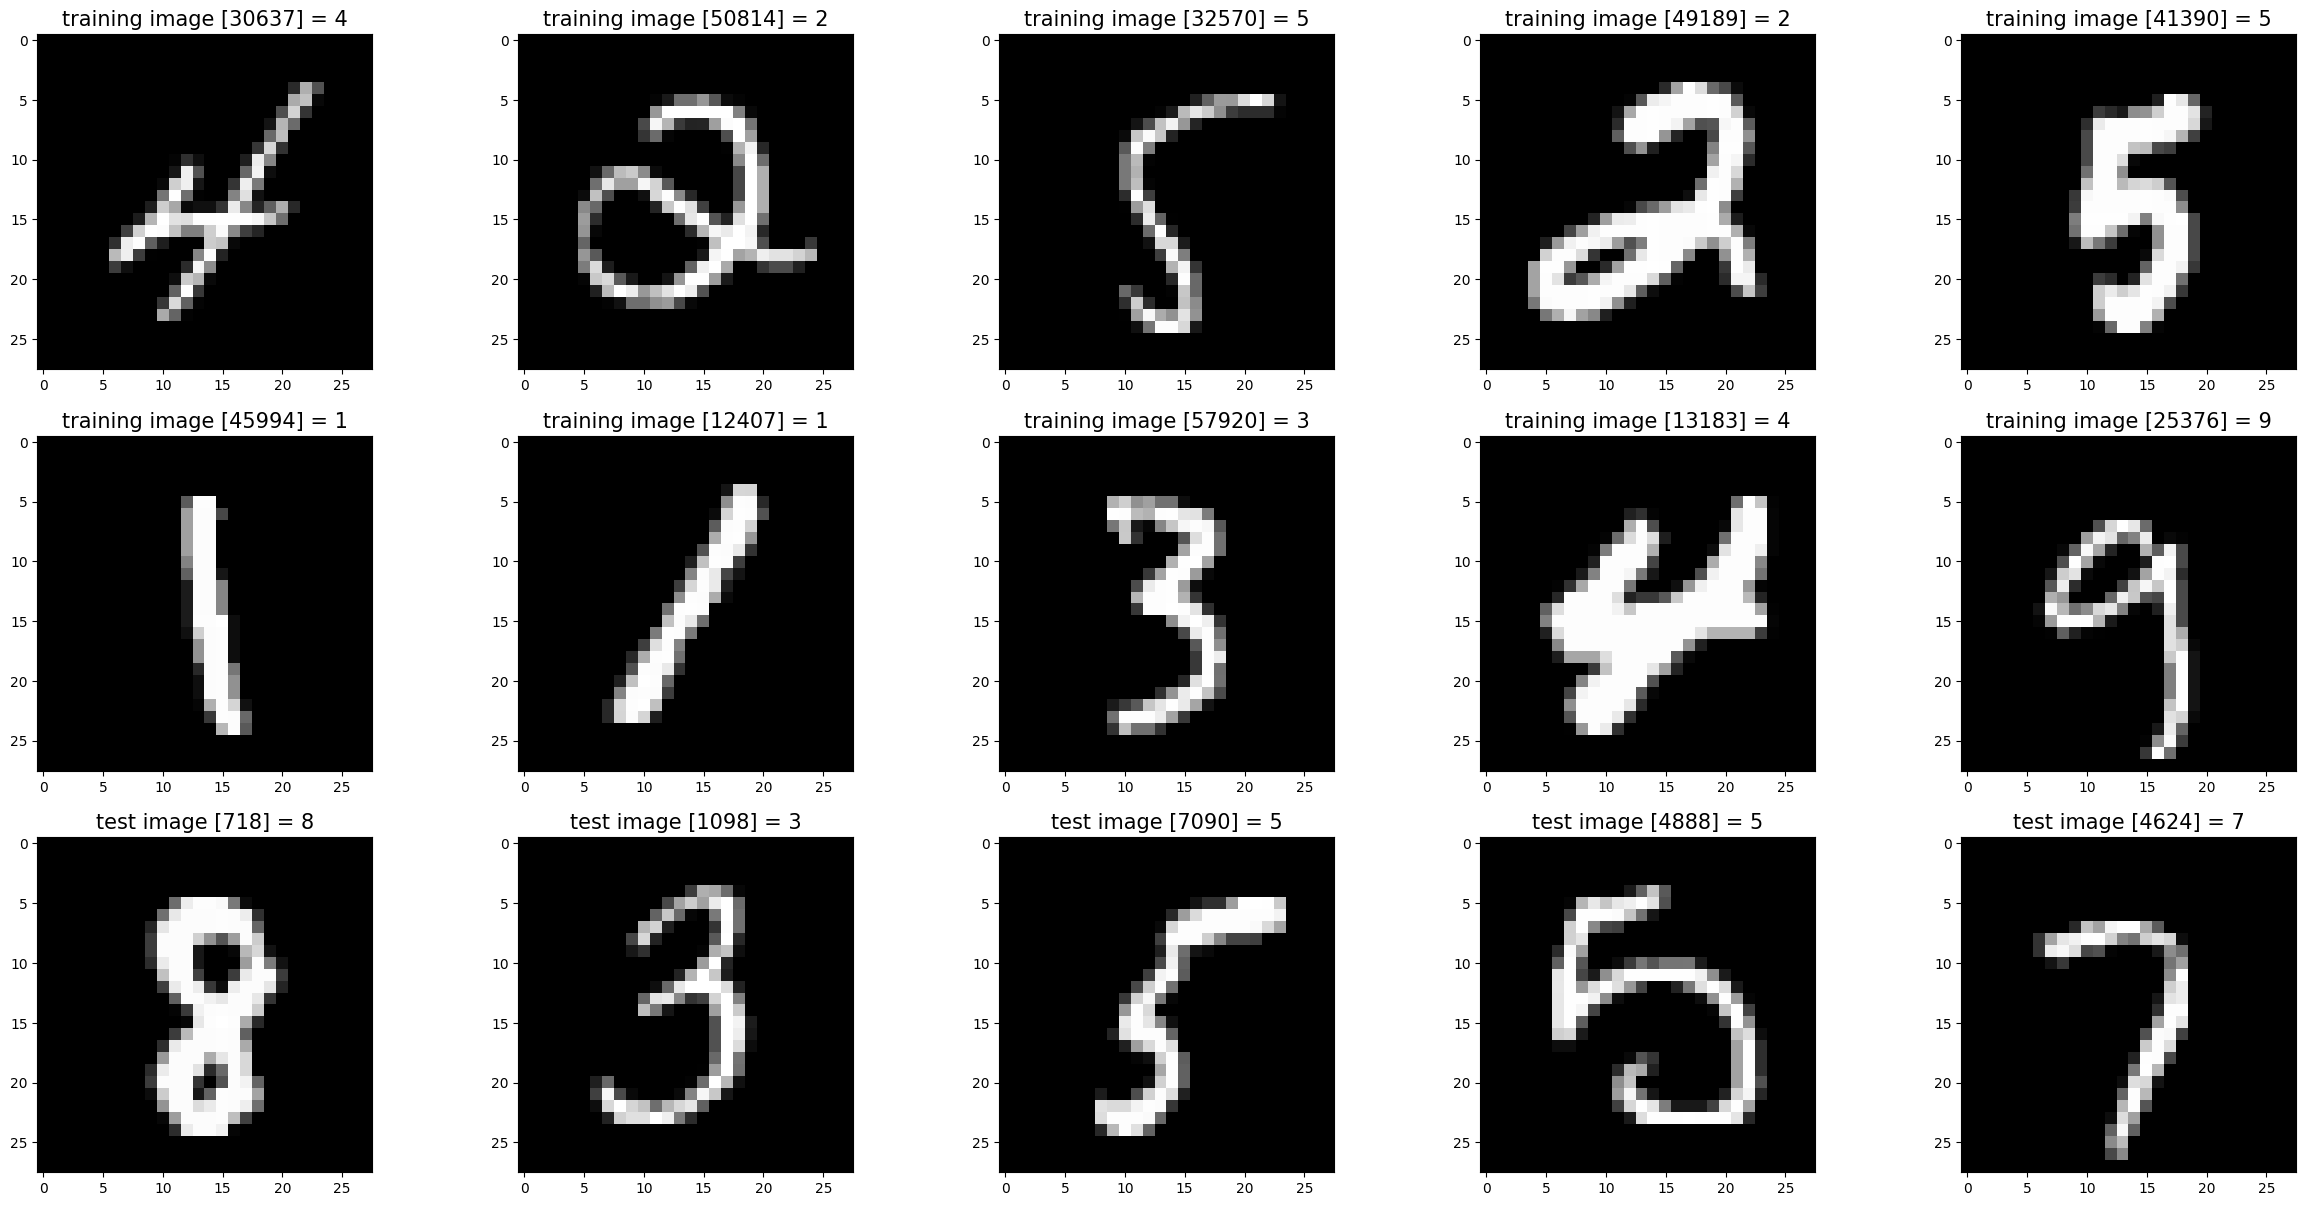

In [65]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'MNIST_Dataset'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)


#### Convert the data to numpy arrays

In [66]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int64)
y_test = np.array(y_test, dtype=np.int64)

#### Normalizing data to be in range [0, 1]

In [67]:
x_train /= 255.0
x_test /= 255.0

#### Combine and flatten data

In [68]:
X = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

X_flat = X.reshape(len(X), -1)  # (N, 784)


#### split data into training (60%), validation (20%), and test (20%) and flatten them

In [69]:
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

X_train_flat = X_train_full.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

#### Convert all to PyTorch tensors

In [70]:
X_train_img = torch.tensor(X_train_full).unsqueeze(1)  # (N, 1, 28, 28)
X_val_img = torch.tensor(X_val).unsqueeze(1)
X_test_img = torch.tensor(X_test).unsqueeze(1)

X_train_flat = torch.tensor(X_train_flat)
X_val_flat = torch.tensor(X_val_flat)
X_test_flat = torch.tensor(X_test_flat)

y_train_t = torch.tensor(y_train_full)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

#### Create TensorDatasets

In [71]:
train_dataset_img = TensorDataset(X_train_img, y_train_t)
val_dataset_img = TensorDataset(X_val_img, y_val_t)
test_dataset_img = TensorDataset(X_test_img, y_test_t)

train_dataset_flat = TensorDataset(X_train_flat, y_train_t)
val_dataset_flat = TensorDataset(X_val_flat, y_val_t)
test_dataset_flat = TensorDataset(X_test_flat, y_test_t)

#### Create DataLoaders

In [72]:
train_loader_img = DataLoader(train_dataset_img, batch_size=64, shuffle=True)
val_loader_img = DataLoader(val_dataset_img, batch_size=64, shuffle=False)
test_loader_img = DataLoader(test_dataset_img, batch_size=64, shuffle=False)

train_loader_flat = DataLoader(train_dataset_flat, batch_size=64, shuffle=True)
val_loader_flat = DataLoader(val_dataset_flat, batch_size=64, shuffle=False)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=64, shuffle=False)

#### Verify Data Preparation

In [73]:
print(f"Train: {len(train_dataset_img)}, Val: {len(val_dataset_img)}, Test: {len(test_dataset_img)}")
print("Example batch:")
batch_imgs, batch_labels = next(iter(train_loader_img))
print(batch_imgs.shape, batch_labels.shape)

Train: 42000, Val: 14000, Test: 14000
Example batch:
torch.Size([64, 1, 28, 28]) torch.Size([64])


# A3 : Softmax Regression

### A3.1: Helper Functions

#### Core Softmax Functions

In [74]:
def initialize_weights(input_dim=784, num_classes=10):
    #initialize matrix with bias and random weights as a start
    W = np.random.randn(input_dim, num_classes) * 0.01
    b = np.zeros((1, num_classes))
    return W, b

def softmax_forward(X, W, b):
    #forward=make predictions
    logits = X @ W + b
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return logits, probs

def calc_loss_and_accuracy(X, y, W, b):
    #cross entropy loss and acc
    _, probs = softmax_forward(X, W, b)
    predicted_classes = np.argmax(probs, axis=1)
    accuracy = np.mean(predicted_classes == y) * 100
    
    n_samples = len(y)
    correct_class_probs = probs[np.arange(n_samples), y]
    loss = -np.mean(np.log(correct_class_probs + 1e-8))#add epsilon to avoid log(0)
    
    return loss, accuracy, predicted_classes

#### Manual Training Functions

In [ ]:
def train_epoch_sgd(X, y, W, b, learning_rate, batch_size):
    #train single epoch
    n_train = len(X)
    n_batches = n_train // batch_size
    
    # Shuffle training data
    indices = np.random.permutation(n_train)
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    epoch_loss = 0
    
    # Mini-batch SGD
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]
        
     
        logits, probs = softmax_forward(X_batch, W, b)
        
        batch_size_actual = len(y_batch)
        correct_probs = probs[np.arange(batch_size_actual), y_batch]
        batch_loss = -np.mean(np.log(correct_probs + 1e-8))
        epoch_loss += batch_loss
        
        #backwards pass
        y_one_hot = np.zeros_like(probs)
        y_one_hot[np.arange(batch_size_actual), y_batch] = 1
        dlogits = (probs - y_one_hot) / batch_size_actual
        dW = X_batch.T @ dlogits
        db = np.sum(dlogits, axis=0, keepdims=True)

        #wj = wj + theta*alpha
        W -= learning_rate * dW
        b -= learning_rate * db
    
    return W, b, epoch_loss

def train_manual_softmax(X_train, y_train, X_val, y_val, learning_rate=0.01, num_epochs=50, batch_size=64):
    W, b = initialize_weights()
    
    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    n_train = len(X_train)
    n_batches = n_train // batch_size
    
    
    # Training loop
    # an epoch is one complete pass through entire dataset
    for i in range(num_epochs):
        W, b, l = train_epoch_sgd(X_train, y_train, W, b, learning_rate, batch_size)
        
        #eval on training and validation
        train_loss, train_acc, _ = calc_loss_and_accuracy(X_train, y_train, W, b)
        
        val_loss, val_acc, _ = calc_loss_and_accuracy(X_val, y_val, W, b)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
    
    return W, b, train_losses, train_accuracies, val_losses, val_accuracies

#### PyTorch Training Functions

In [ ]:
def evaluate_pytorch_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    predictions = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            predictions.extend(predicted.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, np.array(predictions)

def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, =True):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        val_loss, val_acc, _ = evaluate_pytorch_model(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    return train_losses, train_accs, val_losses, val_accs

#### Evaluation and Analysis Functions

In [77]:
def calc_per_class_accuracy(y_true, y_pred, num_classes=10):
    per_class_acc = []
    
    for class_idx in range(num_classes):
        class_mask = (y_true == class_idx)
        class_correct = np.sum((y_pred == class_idx) & class_mask)
        class_total = np.sum(class_mask)
        acc = (class_correct / class_total) * 100 if class_total > 0 else 0
        per_class_acc.append(acc)
    
    return per_class_acc

#### Visualization Functions

In [78]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                         pytorch_train_losses, pytorch_val_losses, 
                         pytorch_train_accs, pytorch_val_accs):
    """Plot training curves comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(train_losses, label='Manual - Train', linewidth=2, linestyle='--')
    ax1.plot(val_losses, label='Manual - Val', linewidth=2, linestyle='--')
    ax1.plot(pytorch_train_losses, label='PyTorch - Train', linewidth=2)
    ax1.plot(pytorch_val_losses, label='PyTorch - Val', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss Comparison: Manual vs PyTorch', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_accs, label='Manual - Train', linewidth=2, linestyle='--')
    ax2.plot(val_accs, label='Manual - Val', linewidth=2, linestyle='--')
    ax2.plot(pytorch_train_accs, label='PyTorch - Train', linewidth=2)
    ax2.plot(pytorch_val_accs, label='PyTorch - Val', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Accuracy Comparison: Manual vs PyTorch', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(y_true, y_pred_manual, y_pred_pytorch):
    """Plot confusion matrices for manual and PyTorch implementations"""
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    cm_manual = confusion_matrix(y_true, y_pred_manual)
    cm_pytorch = confusion_matrix(y_true, y_pred_pytorch)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=np.arange(10))
    disp1.plot(cmap='Blues', ax=ax1, values_format='d')
    ax1.set_title('Confusion Matrix - Manual Implementation', fontsize=14, fontweight='bold')

    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=np.arange(10))
    disp2.plot(cmap='Greens', ax=ax2, values_format='d')
    ax2.set_title('Confusion Matrix - PyTorch Implementation', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    
    return cm_manual, cm_pytorch

def plot_per_class_accuracy(per_class_acc_manual, per_class_acc_pytorch, y_true):
    """Plot per-class accuracy comparison"""
    print("\n" + "="*60)
    print("PER-CLASS ACCURACY ANALYSIS")
    print("="*60 + "\n")

    print("Class | Manual Acc | PyTorch Acc | Test Samples")
    print("-" * 55)
    for i in range(10):
        print(f"  {i}   |   {per_class_acc_manual[i]:5.2f}%  |   {per_class_acc_pytorch[i]:5.2f}%   |     {np.sum(y_true == i):4d}")

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(10)
    width = 0.35

    bars1 = ax.bar(x - width/2, per_class_acc_manual, width, label='Manual', color='steelblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, per_class_acc_pytorch, width, label='PyTorch', color='seagreen', edgecolor='black')

    ax.set_xlabel('Digit Class', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Per-Class Accuracy Comparison: Manual vs PyTorch', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_ylim([0, 105])
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()
    
    return np.argmax(per_class_acc_manual), np.argmin(per_class_acc_manual), np.argmax(per_class_acc_pytorch), np.argmin(per_class_acc_pytorch)

#### Reporting Functions

In [79]:
def print_confusion_matrix_stats(cm_manual, cm_pytorch, y_true):    
    print("\nManual Implementation:")
    print(f"Diagonal sum (correct predictions): {np.trace(cm_manual)}")
    print(f"Total predictions: {np.sum(cm_manual)}")
    print(f"Accuracy from CM: {(np.trace(cm_manual) / np.sum(cm_manual)) * 100:.2f}%")

    print("\nPyTorch Implementation:")
    print(f"Diagonal sum (correct predictions): {np.trace(cm_pytorch)}")
    print(f"Total predictions: {np.sum(cm_pytorch)}")
    print(f"Accuracy: {(np.trace(cm_pytorch) / np.sum(cm_pytorch)) * 100:.2f}%")

def print_per_class_stats(per_class_acc_manual, per_class_acc_pytorch, best_manual, worst_manual, best_pytorch, worst_pytorch):
    print(f"\nManual Implementation:")
    print(f"  Best performing class: {best_manual} ({per_class_acc_manual[best_manual]:.2f}%)")
    print(f"  Worst performing class: {worst_manual} ({per_class_acc_manual[worst_manual]:.2f}%)")

    print(f"\nPyTorch Implementation:")
    print(f"  Best performing class: {best_pytorch} ({per_class_acc_pytorch[best_pytorch]:.2f}%)")
    print(f"  Worst performing class: {worst_pytorch} ({per_class_acc_pytorch[worst_pytorch]:.2f}%)")



### A3.2: Initial Evaluation with Random Weights

In [80]:
"""
Softmax Regression Implementation

Goal: Calculate probabilities for digit classes 0-9
- Z = W^T * x + b (linear transformation)
- Probabilities via softmax: exp(z_i) / Σ(exp(z_j))
- Loss via cross-entropy: -1/n * Σ log(p_correct)
"""

# Prepare numpy arrays for training
X_train_np = X_train_flat.numpy()
X_val_np = X_val_flat.numpy()
X_test_np = X_test_flat.numpy()
y_val_np = y_val
y_test_np = y_test

# Initialize weights and biases
W, b = initialize_weights()

# Forward pass with random weights , measure predictions, accuracy and cross entropy loss for this to build upon it for GD
initial_loss, initial_accuracy,_= calc_loss_and_accuracy(X_train_np, y_train_full, W, b)

print(f"Initial accuracy with random weights: {initial_accuracy:.2f}%")
print(f"Initial loss: {initial_loss:.4f}")

Initial accuracy with random weights: 12.40%
Initial loss: 2.3029


### A3.3: SGD Training Loop

In [81]:
# Training loop
# an epoch is one complete pass through entire dataset
W, b, train_losses, train_accuracies, val_losses, val_accuracies = train_manual_softmax(X_train_np, y_train_full, X_val_np, y_val_np, learning_rate=0.01, num_epochs=50, batch_size=64,=True)

test_loss, test_acc, test_pred = calc_loss_and_accuracy(X_test_np, y_test_np, W, b)

print("Final Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Starting Softmax Regression Training with SGD
Learning rate: 0.01
Batch size: 64
Total samples: 42000
Batches per epoch: 656

Final Test Results:
Test Loss: 0.3047
Test Accuracy: 91.37%
Final Test Results:
Test Loss: 0.3047
Test Accuracy: 91.37%


### A3.4: PyTorch Built-in Implementation

In [82]:
print("Comparing with PyTorch Built-in Implementation")

#PyTorch model
class SoftmaxRegressionPyTorch(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(SoftmaxRegressionPyTorch, self).__init__()
        
        # self.linear creates a fully connected linear layer (also called dense layer)
        # It performs the operation: output = input @ W^T + b
        # 
        # Parameters:
        #   - input_dim (784): Number of input features (28×28 flattened image)
        #   - num_classes (10): Number of output classes (digits 0-9)
        #
        # This layer automatically creates and manages:
        #   - Weight matrix W: shape (10, 784) - learned during training
        #   - Bias vector b: shape (10,) - learned during training
        #
        # Note: PyTorch stores weights as (out_features, in_features), which is 
        # transposed compared to manual implementation where W is (784, 10)
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        # When called, self.linear(x) calcs:
        # logits = x @ self.linear.weight.T + self.linear.bias
        # Input: (batch_size, 784) → Output: (batch_size, 10)
        return self.linear(x)

pytorch_model = SoftmaxRegressionPyTorch()
pytorch_criterion = nn.CrossEntropyLoss()
pytorch_optimizer = optim.SGD(pytorch_model.parameters(), lr=0.01)

print("Training PyTorch model...")
pytorch_train_losses, pytorch_train_accs, pytorch_val_losses, pytorch_val_accs = train_pytorch_model(
    pytorch_model, train_loader_flat, val_loader_flat, pytorch_criterion, pytorch_optimizer, num_epochs, =True
)

# Test evaluation
_, pytorch_test_acc, pytorch_test_preds = evaluate_pytorch_model(pytorch_model, test_loader_flat, pytorch_criterion)

print("Final Comparison: Manual vs PyTorch")

print(f"Manual Implementation Test Accuracy: {test_acc:.2f}%")
print(f"PyTorch Implementation Test Accuracy: {pytorch_test_acc:.2f}%")

SyntaxError: invalid syntax (2779231472.py, line 35)

### A3.5: Training Curves, Confusion Matrix & Per-Class Analysis

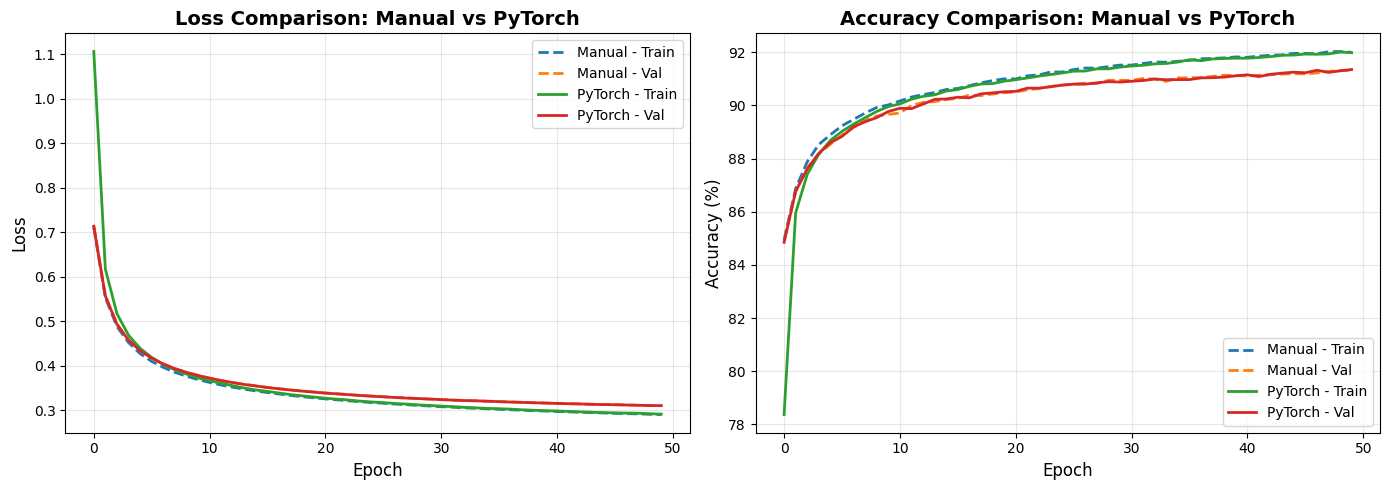

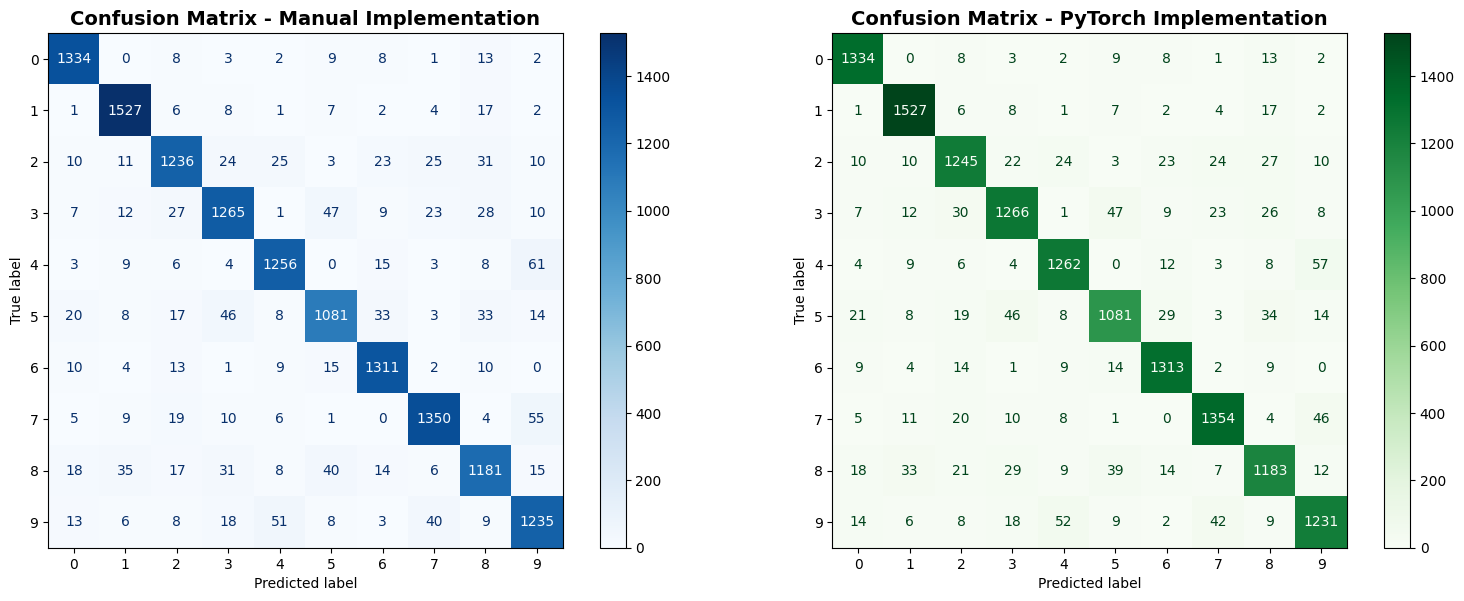


CONFUSION MATRIX ANALYSIS


Manual Implementation:
  Diagonal sum (correct predictions): 12776
  Total predictions: 14000
  Accuracy from CM: 91.26%

PyTorch Implementation:
  Diagonal sum (correct predictions): 12796
  Total predictions: 14000
  Accuracy from CM: 91.40%

PER-CLASS ACCURACY ANALYSIS

Class | Manual Acc | PyTorch Acc | Test Samples
-------------------------------------------------------
  0   |   96.67%  |   96.67%   |     1380
  1   |   96.95%  |   96.95%   |     1575
  2   |   88.41%  |   89.06%   |     1398
  3   |   88.52%  |   88.59%   |     1429
  4   |   92.01%  |   92.45%   |     1365
  5   |   85.59%  |   85.59%   |     1263
  6   |   95.35%  |   95.49%   |     1375
  7   |   92.53%  |   92.80%   |     1459
  8   |   86.52%  |   86.67%   |     1365
  9   |   88.79%  |   88.50%   |     1391


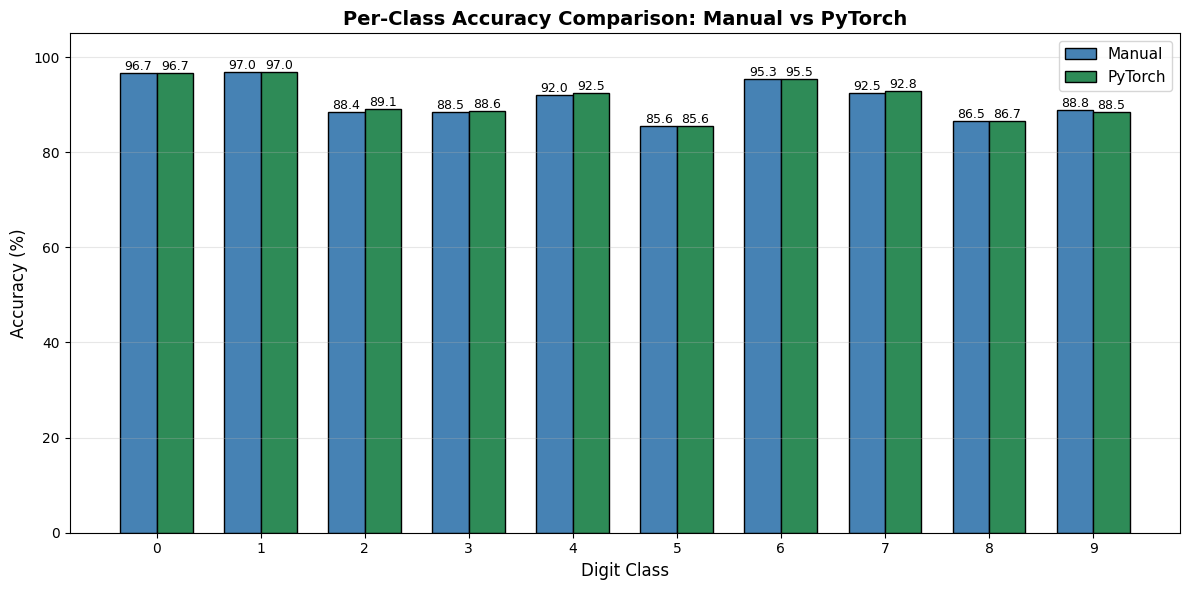


Manual Implementation:
  Best performing class: 1 (96.95%)
  Worst performing class: 5 (85.59%)

PyTorch Implementation:
  Best performing class: 1 (96.95%)
  Worst performing class: 5 (85.59%)


In [ ]:

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,
                    pytorch_train_losses, pytorch_val_losses, pytorch_train_accs, pytorch_val_accs)

cm_manual, cm_pytorch = plot_confusion_matrices(y_test_np, test_pred, pytorch_test_preds)
print_confusion_matrix_stats(cm_manual, cm_pytorch, y_test_np)

per_class_acc_manual = calc_per_class_accuracy(y_test_np, test_pred)
per_class_acc_pytorch = calc_per_class_accuracy(y_test_np, pytorch_test_preds)

best_class_manual, worst_class_manual, best_class_pytorch, worst_class_pytorch = plot_per_class_accuracy(
    per_class_acc_manual, per_class_acc_pytorch, y_test_np
)

print_per_class_stats(per_class_acc_manual, per_class_acc_pytorch, 
                     best_class_manual, worst_class_manual, 
                     best_class_pytorch, worst_class_pytorch)